# Tree Numbers and Subsampling Features

### Introduction

In previous lessons we saw the different mechanisms that random forests increase the variance between individual trees, and then reduce that variance through aggregation.  So far we have an increase of variance with subsampling and bootstrapping.  These two components are the default behavior of random forests.  

In this lesson, we will look at hyperparameters particular to random forests that also change the variance and aggregation of the trees.

### Loading Data

Once again, let's work with our diabetes dataset.

In [4]:
from sklearn.model_selection import train_test_split
import json
with open('types.json', 'r') as f:
    data_types = json.load(f)

import pandas as pd
df = pd.read_feather('cleaned_df.feather')
X = df.drop(columns=['price'])
y = df.price

X_train, X, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Number of trees

One hyperparameter that we can vary with sklearn is the number of estimators of our random forest.  Now, in general, increasing the number of trees should improve our model.  With more trees, our trees will be more varied, thus reducing the error due to variance when we aggregate our trees.  In addition, we expect more of our trees to find the underlying pattern in the data thus reducing the bias of our random forest.  

However, at a certain point, adding new estimators will only provide a small benefit as they begin to be similar to earlier trained estimators.  At this point, the main cost is simply the time that it takes to work on our random forest. 

Let's see the benefit of adding additional trees.  We can do so by training one large random forest, and then seeing the improvement of including an additional estimator.

In [3]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
import numpy as np
tree_predictions = np.vstack([estimator.predict(X_val) for estimator in rfr.estimators_])

Each row of `tree_predictions` contains a separate prediction for each observation in the validation set made by the respective tree.

In [30]:
tree_predictions.shape

(100, 3609)

Then we can see the benefit of taking the mean aggregation of each additional tree.

In [11]:
from sklearn.metrics import r2_score
r2_scores = [r2_score(y_val, np.mean(tree_predictions[:i + 1], axis = 0)) for i in range(0, 100)]
x_vals = list(range(1, 100))

Let's plot the data.

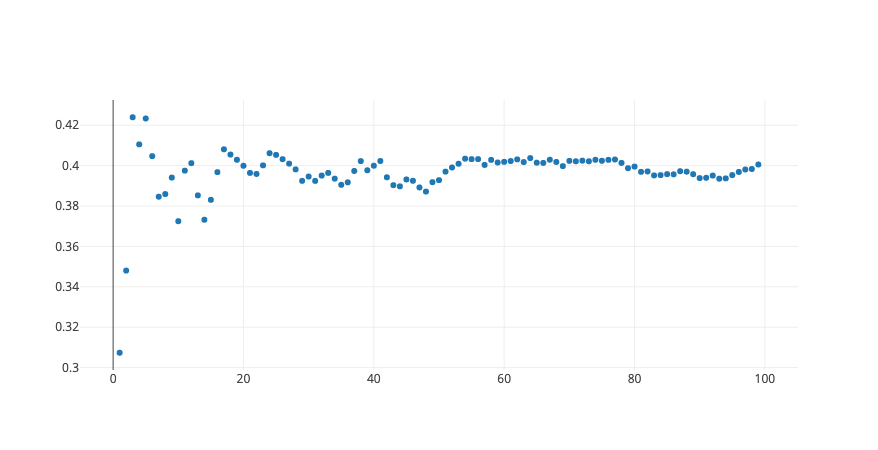

In [32]:
from graph import trace_values, plot
trace = trace_values(x_vals, r2_scores)
plot([trace])

So we can see that our accuracy level stabalizes around 55 trees.  Fitting this model with fifty five trees still takes a while, so just for the purpose of developing our model, we'll knock it down to 20 trees, which also performs well.

In [25]:
%timeit
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 20)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Subsampling Features

The next hyperparameter to work with is sampling the features at each split.  Here is how it works:

* For each split, the random forest first takes a random sample of the features, and then determines what what the next best split is from this subsample.  

The idea behind this is to again increase the variation of the trees.  The problem if that certain features are dominant, the features will be repeatedly selected early and this can have a large impact on what occurs later in the trees.  

Let's see this by looking at the first two estimators of the random forest we just trained.

* plot the first estimator, with the plot set to a max_depth of 1

In [26]:
from plot_tree import plot_tree

* plot the second estimator, with the plot set to a max_depth of 1

What's the problem here?

So we can see that even with subsampling and bootstrapping our data, two of the first three nodes are the same.  This means that immediately, we are dividing up the data similarly, and this decreases the variance among our trees.

One way of reducing this repetition among trees, is to restrict the types of parameters that can be selected for each split.  We do this by selecting a different random sample of features for each split, and then find the best feature to split among this subset.  In sklearn, our random forest can be initialized with a `max_features` argument, with any of the following values:

> * If int, then consider max_features features at each split.
> * If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
> * If “auto”, then max_features=n_features.
> * If “sqrt”, then max_features=sqrt(n_features).
> * If “log2”, then max_features=log2(n_features).


For now let's just see what happens if we train a single random forest using `max_features = 'log_2'`, fit a new `RandomForestRegressor` on our training set, and set `n_estimators` to 20, with the `max_features` parameter also set.

In [27]:
rfr_max_log = None

Now plot the first and second estimators again.

In [29]:
# plot_tree()

In [30]:
# plot_tree()

As you can see, our trees are now more varied.  Subsampling the features allow the random forest to find different trends in the data by increasing the variance of the trees.  

### Combining Feature Subsampling with Max Features

Now create a random forest for each of the parameters with values of .5, 'sqrt', 'log2', and 'auto'.  Each tree should have `n_estimators` equal to 50, and `random_state = 1`. 

Store the random forests in a list of name `max_param_trees`.  Each element in the list should be of the form [parameter, RandomForestRegressor] (see answer below). 

In [65]:
from sklearn.ensemble import RandomForestRegressor

max_param_trees = []

In [66]:
len(max_param_trees)

0

In [59]:
max_param_trees[0]

# [0.5, RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
#             max_features=0.5, max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
#             oob_score=False, random_state=None, verbose=0, warm_start=False)]

[0.5, RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)]

In [60]:
dict_scores = dict(scores)

In [62]:
import numpy as np
half = dict_scores[.5]
sqrt = dict_scores['sqrt']
log2 = dict_scores['log2']
auto = dict_scores['auto']

tree_predictions_half = np.vstack([estimator.predict(X_val) for estimator in half.estimators_])
tree_predictions_sqrt = np.vstack([estimator.predict(X_val) for estimator in sqrt.estimators_])
tree_predictions_log2 = np.vstack([estimator.predict(X_val) for estimator in log2.estimators_])
tree_predictions_auto = np.vstack([estimator.predict(X_val) for estimator in auto.estimators_])

In [63]:
import numpy as np
from sklearn.metrics import r2_score
r2_scores_half = [r2_score(y_val, np.mean(tree_predictions_half[:i + 1], axis = 0)) for i in range(0, 50)]
r2_scores_sqrt = [r2_score(y_val, np.mean(tree_predictions_sqrt[:i + 1], axis = 0)) for i in range(0, 50)]
r2_scores_log2 = [r2_score(y_val, np.mean(tree_predictions_log2[:i + 1], axis = 0)) for i in range(0, 50)]
r2_scores_auto = [r2_score(y_val, np.mean(tree_predictions_auto[:i + 1], axis = 0)) for i in range(0, 50)]

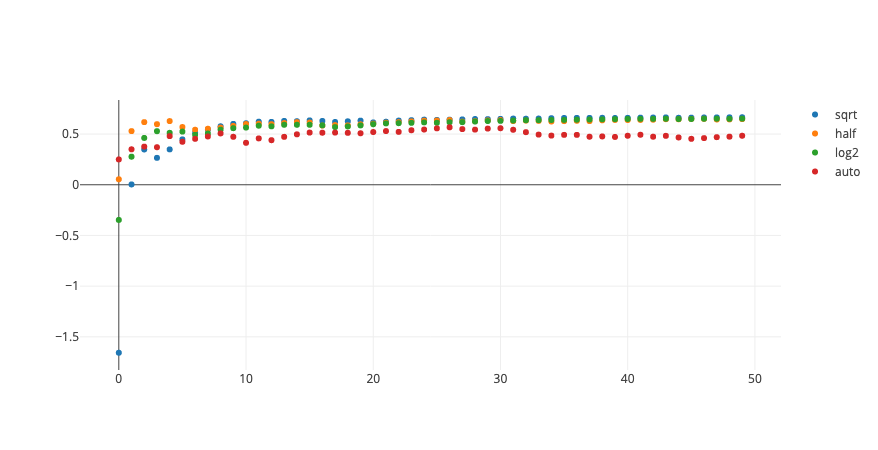

In [64]:
from graph import trace_values, plot
x_vals = list(range(0, 50))
sqrt_trace = trace_values(x_vals,r2_scores_sqrt, name = 'sqrt')
half_trace = trace_values(x_vals,r2_scores_half, name = 'half')
log2_trace = trace_values(x_vals,r2_scores_log2, name = 'log2')
auto_trace = trace_values(x_vals,r2_scores_auto, name = 'auto')
plot([sqrt_trace, half_trace, log2_trace, auto_trace])

What takeaways do you have from the above graph?  How does number of trees change now that we added in a `max_features` hyperparameter?  Why might that be the case?

### Early Stopping

The last hyperparameter for us to work with is the early stopping parameter that we saw with decision trees.  Let's work with different amounts of `min_samples_leaf` to see what is an ideal number.  We'll let you take this one on your own.

### Evaluate

Finally, retrain your final model and evaluate it's performance on the test set.

### Summary

### Resources

[RF top to bottom](https://www.gormanalysis.com/blog/random-forest-from-top-to-bottom/)